In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import array

import ipyvolume as ipv

In [2]:
#generate linear trajectory from point1 to point2
def linspace3D(point1,point2,length):
    v1 = np.linspace(point1[0],point2[0],length)
    v2 = np.linspace(point1[1],point2[1],length)
    v3 = np.linspace(point1[2],point2[2],length)
    line = np.zeros(shape=[length,3])
    line[:,0]=v1
    line[:,1]=v2
    line[:,2]=v3
    return line

#calculate distance between two points
def get_dis_points(pointA, pointB):
    x1 = pointA[0]
    y1 = pointA[1]
    z1 = pointA[2]
    x2 = pointB[0]
    y2 = pointB[1]
    z2 = pointB[2]
    dist = math.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2 + (z1 - z2) ** 2)
    return dist

#convert polar coordinates to cartesian
def polar2cart(r,phi,theta):
    x = []
    y = []
    z = []
    for i in range(len(phi)):
        for j in range(len(theta)):
            x.append(r*math.sin(theta[j])*math.cos(phi[i]))
            y.append(r*math.sin(theta[j])*math.sin(phi[i]))
            z.append(r*math.cos(theta[j]))
    x = np.array(x)
    y = np.array(y)
    z = np.array(z)
    return x,y,z

In [3]:
#size of field
size = [100, 100, 100]

#number of drons
n_drone = 2

#save distance
r_save = 20

#radious of scan
r_scan = 5

number_of_vectors = 40

#start point
start_point = [[0, 50, 50], [50, 0, 50]]
#target point
finish_point = [[100, 50, 50], [50, 100, 50]]

#distance from start to finish
r0 = np.zeros(n_drone)
for i in range(n_drone):
    r0[i] = get_dis_points(start_point[i], finish_point[i])

In [4]:
#----make angels to scan field----
phi = []
theta = []
pi = math.pi
for i in range(number_of_vectors+1):
    phi.append(i*2*pi/number_of_vectors)
    theta.append(i*2*pi/number_of_vectors)
phi = np.array(phi)
theta = np.array(theta)

#----convert angels to coordinates----
x = np.zeros(shape=(n_drone,len(phi)*len(theta)))
y = np.zeros(shape=(n_drone,len(phi)*len(theta)))
z = np.zeros(shape=(n_drone,len(phi)*len(theta)))

for k in range(n_drone):
    x[k],y[k],z[k] = polar2cart(r_scan, phi, theta)
    #shift to start point
    x[k] += start_point[k][0]
    y[k] += start_point[k][1]
    z[k] += start_point[k][2]

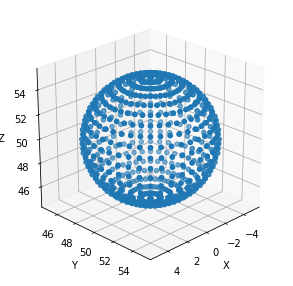

In [5]:
#----check plot scan coordinates----
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(x[0],y[0],z[0]);
#ax.scatter(next_point[0][0], next_point[0][1], next_point[0][2], color=color_drone[0], marker='*', s=150)

ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
ax.view_init(25, 45)
plt.show()

In [6]:
#---setup new generation---
finish_traj = [1,1]

#start point
start_point = [[0, 50, 50], [50, 0, 52]]
#target point
finish_point = [[100, 50, 50], [50, 100, 52]]
next_point = start_point

next_point = np.zeros(shape=(n_drone,3))
#----Firts point----

traj_x = [start_point[0][0]]; traj_y = [start_point[0][1]]; traj_z = [start_point[0][2]]
traj_x2 = [start_point[1][0]]; traj_y2 = [start_point[1][1]]; traj_z2 = [start_point[1][2]]

#----convert angels to coordinates----
x = np.zeros(shape=(n_drone,len(phi)*len(theta)))
y = np.zeros(shape=(n_drone,len(phi)*len(theta)))
z = np.zeros(shape=(n_drone,len(phi)*len(theta)))

for k in range(n_drone):
    x[k],y[k],z[k] = polar2cart(r_scan, phi, theta)
    #shift to start point
    x[k] += start_point[k][0]
    y[k] += start_point[k][1]
    z[k] += start_point[k][2]   

In [7]:
field_target = np.zeros(shape=(n_drone,len(x[0])))
field_obs = np.zeros(shape=(n_drone,len(x[0])))
field_total = np.zeros(shape=(n_drone,len(x[0])))

while finish_traj[0] == 1 or finish_traj[1] == 1:
    max_f = np.zeros(n_drone)
    
    for k in range(n_drone):
        if (finish_traj[k] == 1):
            max_f[k] = 0
            for i in range(len(x[0])):
                point = [x[k][i], y[k][i], z[k][i]]
                r_t = get_dis_points(point, finish_point[k])
                field_target[k][i] = (r0[k]*2 - r_t)**2

                if k == 0:
                    r_obs = get_dis_points(point, next_point[1])
                    if (r_obs <= r_save):
                        field_obs[0][i] = (r_save - r_obs)**2
                        
                if k == 1:
                    r_obs = get_dis_points(point, next_point[0])
                    if (r_obs <= r_save):
                        field_obs[1][i] = (r_save - r_obs)**2

                field_total[k][i] = field_target[k][i] - field_obs[k][i]*20

                if (field_total[k][i] > max_f[k]):
                    max_f[k] = field_total[k][i]
                    next_point[k] = point
                    if (r_t < r_scan):
                        next_point[k] = finish_point[k]
                        finish_traj[k] = 0
                
    for k in range(n_drone):
        x[k],y[k],z[k] = polar2cart(r_scan, phi, theta)
        #shift to start point
        x[k] += next_point[k][0]
        y[k] += next_point[k][1]
        z[k] += next_point[k][2]

    traj_x.append(next_point[0][0])
    traj_y.append(next_point[0][1])
    traj_z.append(next_point[0][2])
    
    traj_x2.append(next_point[1][0])
    traj_y2.append(next_point[1][1])
    traj_z2.append(next_point[1][2])

In [8]:
traj_x = np.array(traj_x); traj_y = np.array(traj_y); traj_z = np.array(traj_z);
traj_x2 = np.array(traj_x2); traj_y2 = np.array(traj_y2); traj_z2 = np.array(traj_z2);

k_st = 0
k_f = 22

fig = ipv.figure(figsize=(10,10))
scatter = ipv.scatter(traj_x[k_st:k_f],traj_y[k_st:k_f],traj_z[k_st:k_f], marker='sphere', color='red', size=1)
scatter = ipv.scatter(traj_x2[k_st:k_f],traj_y2[k_st:k_f],traj_z2[k_st:k_f], marker='sphere', color='blue', size=1)
ipv.xyzlim(0, 100)

ipv.show()

print(len(traj_x), len(traj_x2))

22 22
